In [ ]:
import io, sys, math, re
import collections
import string
import math
import itertools
from collections import defaultdict
import matplotlib.pyplot as plt
import numpy as np

# Problem 1: Language Modeling

## Import Brown corpus

In [ ]:
from nltk.corpus import brown
import nltk
nltk.download('brown')
brown.words()
sentence = ' '.join(brown.words())
# returns a list of sentences seperated by newline in the main corpus/text.    
brown_sentence = re.compile('[.!?] ').split(sentence)

[nltk_data] Downloading package brown to /root/nltk_data...
[nltk_data]   Unzipping corpora/brown.zip.


## Word pre process

In [ ]:
def tokenize_sentence(sentence):
    sentence = [i.strip("''").split(" ") for i in sentence] 
    return sentence

In [ ]:
def prep_data(sentence):
    for i in range(len(sentence)):
        sentence[i] = [''.join(c for c in s if c not in string.punctuation) for s in sentence[i]] # remove punctuations
        sentence[i] = [s for s in sentence[i] if s]          # removes empty strings
        sentence[i] = [word.lower() for word in sentence[i]] # lower 
        sentence[i] += ['</s>'] # Append </s> at the end of each sentence in the corpus
        sentence[i].insert(0, '<s>')  # Append <s> at the beginning of each sentence in the corpus
    return sentence

## Split data into training, developing, test
### Training (70%),Developing (10%), and Test data (20%)

In [ ]:
brown = tokenize_sentence(brown_sentence)
brown = prep_data(brown)

def split_st(data,n,m): 
    length = len(data)
    l = int(round(len(data)*n))
    train = data[1:l]
    test_data = data[l:length]
    d = int(round(len(train)*m))
    val_data  = train[1:d]
    train= train[d:l]
    return (train, val_data, test_data)

train_data,val_data,test_data = split_st(brown, 0.8, 1/8)

## (A) Report the perplexity of your unigram and bigram models on the both training data and test data

### Build N-gram model

In [ ]:
def build_ngrams(data, n):
    '''
    Parameters:
    data: each list is a sentence of the text 
    n: size of the n-gram
    
    Returns:
    proba: {context: {word:probability of this word given context}}
    '''
    count_words = 0
    ngram_counts = defaultdict(lambda: defaultdict(float))

    for sentence in data:
        sentence = tuple(sentence)
        # by using the context as a key and the word as a value
        for i in range(len(sentence)):
            count_words += 1 
            for j in range(n):
                if i-j < 0:
                    break
                ngram_counts[sentence[i-j:i]][sentence[i]] += 1



    probability  = defaultdict(lambda: defaultdict(float))
    # Build the probabilities from the counts
    for context in ngram_counts.keys():
        denominator = 0
        for word in ngram_counts[context].keys():
            denominator += ngram_counts[context][word]
        for word in ngram_counts[context].keys():
            probability[context][word] = ngram_counts[context][word]/denominator


    
    return probability

In [ ]:
uni_train = build_ngrams(train_data, 1)
bi_train = build_ngrams(train_data, 2)
val_uni = build_ngrams(val_data, 1)
val_bi = build_ngrams(val_data, 2)
uni_test = build_ngrams(test_data, 1)
bi_test = build_ngrams(test_data, 2)

### Probability against each N-gram.

In [ ]:
def get_prob(model, context, word):
    '''
    context (list of strings): a sentence
    w(string): the word we need to find it's probability given the context
    
    return: probability of this word given the context 
    '''
    return model[context][word]

### Calculate the perplexity 

In [ ]:
def perplexity(model, data, n):

    #the preplexity of the model 
  
    perp, T = 0.0, 0
    for sentence in data:
        sentence = tuple(sentence)
        for i in range(1, len(sentence)):
            min_num = min(n-1, i)
            context = sentence[i - min_num:i]
            perp += -math.log(get_prob(model, context, sentence[i]))
            T += 1
    perp = math.exp(perp/T)
    return perp

In [ ]:
def vocab_frequencies(sentence):
    unigram_frequencies = dict() 
    for line in sentence:
        for word in line:
            if word in unigram_frequencies:
                unigram_frequencies[word] = unigram_frequencies.get(word, 0) + 1
            else:
                unigram_frequencies[word] = 1
      
    return unigram_frequencies

In [ ]:
def unknown_words(data, vocab):

    # replace words in data that are not in the vocab 
    data_with_unkown = []
    for sentence in data:
        sentence_with_unkown = []
        for word in sentence:
            if word in vocab:
                sentence_with_unkown.append(word)
            else:
                sentence_with_unkown.append('<UNK>')
        data_with_unkown.append(sentence_with_unkown)

    return data_with_unkown

### Perplexity on train and test data - Unigram Model

In [ ]:
uni_freq = vocab_frequencies(train_data)
uni_train_data = unknown_words(train_data,uni_freq)
uni_freq_test = vocab_frequencies(test_data)
uni_test_data = unknown_words(test_data,uni_freq_test)
uni_val_freq = vocab_frequencies(val_data)
uni_val_data = unknown_words(val_data,uni_val_freq)

In [ ]:
print("N-gram model with N = ", 1)
unigram_model_train = build_ngrams(uni_train_data, 1)
unigram_model_test = build_ngrams(uni_test_data, 1)
print("The Unigram Train Data perplexity is: ", perplexity(unigram_model_train, uni_train_data, n=1))
print("The Unigram Test Data perplexity is: ", perplexity(unigram_model_test, uni_test_data, n=1))

N-gram model with N =  1
The Unigram Train Data perplexity is:  1291.0674052557827
The Unigram Test Data perplexity is:  831.1539904025091


### Perplexity on train and test data - Bigram Model

In [ ]:
bi_freq = vocab_frequencies(train_data)
bi_train_data = unknown_words(train_data,bi_freq)
bi_freq_test = vocab_frequencies(test_data)
bi_test_data = unknown_words(test_data,bi_freq_test)
bi_val_freq = vocab_frequencies(val_data)
bi_val_data = unknown_words(val_data,bi_val_freq)

In [ ]:
print("N-gram model with N = ", 2)
bigram_model_train = build_ngrams(bi_train_data, 2)
bigram_model_test = build_ngrams(bi_test_data, 2)
print("The Bigram Train Data perplexity is: ", perplexity(bigram_model_train, bi_train_data, n=2))
print("The Bigram Test Data perplexity is: ", perplexity(bigram_model_test, bi_test_data, n=2))

N-gram model with N =  2
The Bigram Train Data perplexity is:  79.86967038783126
The Bigram Test Data perplexity is:  42.10487732106337


## (B) Draw a curve that measures your perplexity change over different λ values on the developing data.
### Add λ smoothing on devoloping data - Unigram/Bigram

In [ ]:
def freq_of_unique_words(sentence):
    bag_of_words = list(itertools.chain.from_iterable(sentence)) # change the nested list to one single list
    corpus_word_count = 0 # No of words in the corpus excluding <s> and </s>.
    #count the no. of times a word repeats in the corpus
    count = {}
    for word in bag_of_words:
        if word in count :
            count[word] += 1
        else:
            count[word] = 1
        if word != '<s>' and word != '</s>':
             corpus_word_count +=1
            
    unique_word_count = len(count) 
    return unique_word_count
uni_count_smooth = freq_of_unique_words(uni_train_data)

In [ ]:
# Computes the bigram frequncies
# Bigram frequncies means the number of times a word appears after a given word in the corpus.
# inputs:
# lines - list of lists obtained from "prep_data".
# count - dictionary obtained from "freq_of_unique_words".
# returns - dictionary of bigram frequencies {(word|given word): count(word|given word)} --- count(word|given word)~int.
def compute_bigram_frequencies(lines):
    bigram_frequencies = dict() 
    #unique_bigrams = set()
    for sentence in lines:
        given_word = None
        for word in sentence:
            if given_word != None:
                bigram_frequencies[(given_word, word)] = bigram_frequencies.get((given_word, word),0) + 1
            given_word = word
    #The number of bigram_frquencies in the corpus       
    #print(len(bigram_frequencies))
    return bigram_frequencies
bi_count = compute_bigram_frequencies(bi_train_data)
bi_count_smooth = freq_of_unique_words(bi_count)

In [ ]:
def add_k_smoothing(data,k,n,V):
    '''
    Parameters:
    data: each list is a sentence of the text 
    n: size of the n-gram
    k: 
    
    Returns:
    proba: {context: {word:probability of this word given context}}
    '''
    count_words_smooth = 0
    ngram_counts_smooth = defaultdict(lambda: defaultdict(float))

    for sentence in data:
        sentence = tuple(sentence)
        # by using the context as a key and the word as a value
        for i in range(len(sentence)):
            count_words_smooth += 1 
            for j in range(n):
                if i-j < 0:
                    break
                ngram_counts_smooth[sentence[i-j:i]][sentence[i]] += 1



    probability  = defaultdict(lambda: defaultdict(float))
    # Build the probabilities from the counts
    for context in ngram_counts_smooth.keys():
        denominator = 0
        for word in ngram_counts_smooth[context].keys():
            denominator += ngram_counts_smooth[context][word]
        for word in ngram_counts_smooth[context].keys():
            probability[context][word] = (ngram_counts_smooth[context][word]+k)/(denominator+(V*k))


    
    return probability, ngram_counts_smooth

In [ ]:
def get_prob_smooth(model, context, word, k , V, count_dict):
    '''
    context (list of strings): a sentence
    w(string): the word we need to find it's probability given the context
    
    return: probability of this word given the context 
    '''
    denom = 0
    if context in model and word in model[context]:
        return model[context][word]
    elif context in model and word not in model[context]:
        value = dict(count_dict[context].items())
        denom = sum(value.values())
        return 1/(denom+V*k)
    else:
        return 1/(V*k)
    return model[context][word]

    # def get_prob_smoothing(model, context, w,k,count_dict):
    # denom = 0
    # if context in model and w in model[context]:
    #     return model[context][w]
    # elif context in model and w not in model[context]:
    #     value=dict(count_dict[context].items())
    #     denom = sum(value.values())
    #     return 1/(denom+trn_data_vocabsize*k)
    # else:
    #     return 1/(trn_data_vocabsize*k)

In [ ]:
def perplexity_smooth(model, data, n, k, V, count_dict):
    perp, T = 0.0, 0
    for sentence in data:
        sentence = tuple(sentence)
        for i in range(1, len(sentence)):
            min_num = min(n-1, i)
            context = sentence[i-min_num:i]
            perp += -math.log(get_prob_smooth(model, context, sentence[i],k, V, count_dict))
            T += 1
    perp = math.exp(perp/T)
    return perp

### Unigram

In [ ]:
# add k smoothing 
x_uni=[]
y_uni=[]
print('perplexity for add-k-smoothing on development data-unigram:')
k_ls = [0.0000001,0.000001,0.00001,0.0001,0.001,0.01,0.1,1]
for k in k_ls:
    print('k=:',k)
    print('The add k unigram developing data perplexity is: ')
    uni_addk_prob_dict , count = add_k_smoothing(uni_val_data,k,1, uni_count_smooth)
    prep_smooth = perplexity_smooth(uni_addk_prob_dict, uni_val_data, 1, k, uni_count_smooth,count_dict=count)
    print(prep_smooth)
    x_uni.append(k)
    y_uni.append(prep_smooth)

perplexity for add-k-smoothing on development data-unigram:
k=: 1e-07
The add k unigram developing data perplexity is: 
1151.880052947906
k=: 1e-06
The add k unigram developing data perplexity is: 
1151.880311398827
k=: 1e-05
The add k unigram developing data perplexity is: 
1151.8828959182995
k=: 0.0001
The add k unigram developing data perplexity is: 
1151.9087411323396
k=: 0.001
The add k unigram developing data perplexity is: 
1152.1671947417494
k=: 0.01
The add k unigram developing data perplexity is: 
1154.7518687764114
k=: 0.1
The add k unigram developing data perplexity is: 
1180.6019059737166
k=: 1
The add k unigram developing data perplexity is: 
1434.1963718415664


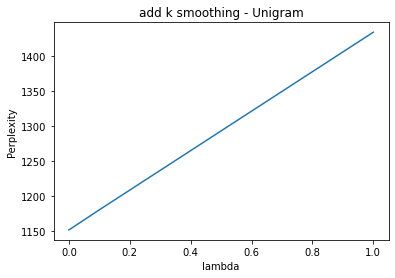

Minimum perplexity 1151.880052947906


In [ ]:
plt.plot(x_uni,y_uni)
plt.xlabel('lambda')
plt.ylabel('Perplexity')
plt.title('add k smoothing - Unigram')
plt.show()
print('Minimum perplexity',min(y_uni))

### Bigram

In [ ]:
# add k smoothing 
x_bi=[]
y_bi=[]
print('perplexity for add-k-smoothing on development data-bigram:')
k_ls = [0.0000001,0.000001,0.00001,0.0001,0.001,0.01,0.1,1]
for k in k_ls:
    print('k=:',k)
    print('The add k bigram developing data perplexity is: ')
    bi_addk_prob_dict , bi_count = add_k_smoothing(bi_val_data,k,2, bi_count_smooth)
    bi_prep_smooth = perplexity_smooth(bi_addk_prob_dict, bi_val_data, 2, k, bi_count_smooth,count_dict=bi_count)
    print(bi_prep_smooth)
    x_bi.append(k)
    y_bi.append(bi_prep_smooth)

perplexity for add-k-smoothing on development data-bigram:
k=: 1e-07
The add k bigram developing data perplexity is: 
30.861610145695586
k=: 1e-06
The add k bigram developing data perplexity is: 
31.009356421718564
k=: 1e-05
The add k bigram developing data perplexity is: 
32.36129071907325
k=: 0.0001
The add k bigram developing data perplexity is: 
41.29736350557426
k=: 0.001
The add k bigram developing data perplexity is: 
83.54462630299147
k=: 0.01
The add k bigram developing data perplexity is: 
289.8796641158628
k=: 0.1
The add k bigram developing data perplexity is: 
1562.6981142574723
k=: 1
The add k bigram developing data perplexity is: 
8887.643708922897


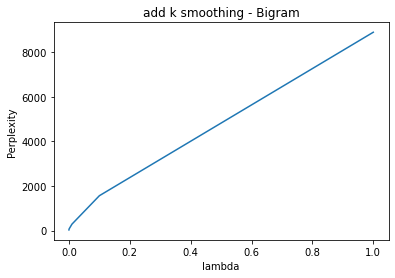

Minimum perplexity 30.861610145695586


In [ ]:
plt.plot(x_bi,y_bi)
plt.xlabel('lambda')
plt.ylabel('Perplexity')
plt.title('add k smoothing - Bigram')
plt.show()
print('Minimum perplexity',min(y_bi))

## (C) Pick the best λ value(s) and train again your unigram and bigram models on training data + developing data.

In [ ]:
uni_index = y_uni.index(min(y_uni))
print('Unigram minimum perplexity',min(y_uni))
print("Best lambda value for unigram: ", x_uni[uni_index])

Unigram minimum perplexity 1151.880052947906
Best lambda value for unigram:  1e-07


In [ ]:
bi_index = y_bi.index(min(y_bi))
print('Bigram minimum perplexity',min(y_bi))
print("Best lambda value for bigram : ", x_bi[bi_index])

Bigram minimum perplexity 30.861610145695586
Best lambda value for bigram :  1e-07


### Train again unigram and bigram models on training data + developing data.

In [ ]:
uni_dataset = uni_train_data + uni_val_data
bi_dataset = bi_train_data + bi_val_data

In [ ]:
# unigram
print("N-gram model with N = ", 1)
uni_model, uni_smooth = add_k_smoothing(uni_dataset,k=1e-07,n=1,V=uni_count_smooth)
uni_model_test, test_smooth =add_k_smoothing(uni_test_data,k=1e-07,n=1,V=uni_count_smooth)
print("The Unigram Train + Develop Data perplexity is: ", perplexity_smooth(uni_model, uni_dataset, n=1, k=1e-07, V=uni_count_smooth , count_dict=uni_smooth))
print("The Unigram Test Data perplexity is: ", perplexity_smooth(uni_model_test, uni_test_data, n=1, k=1e-07, V=uni_count_smooth, count_dict=test_smooth))

N-gram model with N =  1
The Unigram Train + Develop Data perplexity is:  1335.4415053604012
The Unigram Test Data perplexity is:  831.1540021462384


In [ ]:
# bigram
print("N-gram model with N = ", 2)
bi_model, bi_smooth = add_k_smoothing(bi_dataset,k=1e-07,n=2,V=bi_count_smooth)
bi_model_test, bi_test_smooth = add_k_smoothing(bi_test_data,k=1e-07,n=2,V=bi_count_smooth)
print("The Unigram Train + Develop Data perplexity is: ", perplexity_smooth(bi_model, bi_dataset, n=2, k=1e-07, V=bi_count_smooth , count_dict=bi_smooth))
print("The Unigram Test Data perplexity is: ", perplexity_smooth(bi_model_test, bi_test_data, n=2, k=1e-07, V=bi_count_smooth, count_dict=bi_test_smooth))

N-gram model with N =  2
The Unigram Train + Develop Data perplexity is:  83.14523688369151
The Unigram Test Data perplexity is:  42.12102592419681


## (D) Generate random sentences based on the unigram and bigram language models from part (c). 
### Report 5 sentences per model by sampling words from each model continuously until meeting the stop symbol ⟨/s⟩.


In [ ]:
def get_proba_distrib(model, context):
    ## need to get the the words after the context and their probability of appearance
    ## after this context 
    '''
    Parameters: 
    model (dictionary of dictionary)
    {
        context: {word:probability of this word given context}
    }
    context (list of strings): the sentence we need to find the words after it and 
    thier probabilites
    
    Retunrs:
    words_and_probs(dic): {word: probability of word given context}
    
    '''
    # code a recursive function over context
    # to find the longest available ngram
    
    if context in model:
        return model[context]
    else:
        return get_proba_distrib(model, context[1:])

In [ ]:
def generate(model):
    '''
    Retunrs:
    sentence (list of strings): a sentence sampled according to the language model. 
    
    '''
    # generate a sentence. A sentence starts with a <s> and ends with a </s>

    sentence = ["<s>"]
    while sentence[-1] != "</s>" and len(sentence)<100 :
        
        proba = get_proba_distrib(model, tuple(sentence))
        p = np.array(list(proba.values()))
        p /= np.array(list(proba.values())).sum()
        w = np.random.choice((list(proba.keys())), 1, p = p)
        sentence.append(w[0])
    return sentence

### Random sentence for unigram

In [ ]:
# unigram 
print("Generated five random sentence - Unigram: ")
x=[]
for i in range(5):
    i = generate(uni_model)
    sentence = ' '.join(i)
    x.append(sentence)
x

Generated five random sentence - Unigram: 


['<s> have loving miles what and </s>',
 '<s> the </s>',
 '<s> of him we years be there of his that he result duty runs level trouble novelist a day with be </s>',
 '<s> but or i soon is </s>',
 '<s> vice approaching and <s> this the had well war problem as explorer on if talked by there </s>']

### Random sentence for bigram

In [ ]:
# Bigram 
print("Generated five random sentence - Bigram: ")
y=[]
for j in range(5):
    j = generate(bi_model)
    bi_sentence = ' '.join(j)
    y.append(bi_sentence)
y

Generated five random sentence - Bigram: 


['<s> i hear lincolns weeping </s>',
 '<s> with new member of our reading as the sciences might step of which is a societal responsibility for crowding horses </s>',
 '<s> one married students to the new amsterdam theater drawn from the choice was blown up through our plusone so well synchronized flash with the resources available to spend each individual items are migrating </s>',
 '<s> what i supported their influence the ideas all the treble </s>',
 '<s> when poetic professors brain and 4427 procurement of utter misery </s>']

## (E) Choose at least one additional extension to implement. 
### Verify quantitative improvement by measuring 1) the perplexity on test data; and qualitative improvement by retrying 2) the random sentence generation in part (d).


### Trigram Model

In [ ]:
def trigram_prep_data(sentence):
    for i in range(len(sentence)):
        sentence[i] = [''.join(c for c in s if c not in string.punctuation) for s in sentence[i]] # remove punctuations
        sentence[i] = [s for s in sentence[i] if s]          # removes empty strings
        sentence[i] = [word.lower() for word in sentence[i]] # lower 
        sentence[i] += ['</s>'] + ['</s>'] # Append </s> at the end of each sentence in the corpus
        sentence[i].insert(0, '<s>')
        sentence[i].insert(1, '<s>')
        # Append <s> at the beginning of each sentence in the corpus
    return sentence

In [ ]:
tri_brown = tokenize_sentence(brown_sentence)
tri_brown =trigram_prep_data(tri_brown)

def split_st(data,n,m): 
    length = len(data)
    l = int(round(len(data)*n))
    train = data[1:l]
    test_data = data[l:length]
    d = int(round(len(train)*m))
    val_data  = train[1:d]
    train= train[d:l]
    return (train, val_data, test_data)

tri_train_data, tri_val_data,tri_test_data = split_st(tri_brown, 0.8, 1/8)

In [ ]:
tri_freq = vocab_frequencies(tri_train_data)
tri_train_data = unknown_words(tri_train_data,tri_freq)
tri_freq_test = vocab_frequencies(tri_test_data)
tri_test_data = unknown_words(tri_test_data,tri_freq_test)
tri_val_freq = vocab_frequencies(tri_val_data)
tri_val_data = unknown_words(tri_val_data,tri_val_freq)

In [ ]:
type(tri_train_data)
len(tri_train_data)
(tri_train_data)

[['<s>',
  '<s>',
  'so',
  'we',
  'note',
  'approvingly',
  'a',
  'fresh',
  'sample',
  'of',
  'unanimity',
  '</s>',
  '</s>'],
 ['<s>',
  '<s>',
  'all',
  'nine',
  'members',
  'of',
  'the',
  'interamerican',
  'center',
  'authority',
  'voted',
  'for',
  'goodbody',
  'companys',
  'proposal',
  'to',
  'finance',
  'the',
  'longawaited',
  'trade',
  'and',
  'cultural',
  'center',
  '</s>',
  '</s>'],
 ['<s>',
  '<s>',
  'the',
  'widely',
  'known',
  'financial',
  'firm',
  'has',
  '60',
  'days',
  'to',
  'spell',
  'out',
  'the',
  'terms',
  'of',
  'its',
  'contract',
  '</s>',
  '</s>'],
 ['<s>',
  '<s>',
  'if',
  'the',
  'indenture',
  'is',
  'accepted',
  'the',
  'authority',
  'will',
  'proceed',
  'to',
  'validate',
  'a',
  'bond',
  'issue',
  'repayable',
  'from',
  'revenue',
  '</s>',
  '</s>'],
 ['<s>',
  '<s>',
  'then',
  'goodbody',
  'will',
  'hand',
  'over',
  'a',
  'minimum',
  'of',
  '155',
  'million',
  'for',
  'developing',

In [ ]:
def build_ngrams(ngram_dt, n):
    return zip(*[ngram_dt[i:] for i in range(n)])
trig = build_ngrams(tri_train_data,3)
trig = len(list(trig))

In [ ]:
# add k smoothing 
x_tri=[]
y_tri=[]
print('perplexity for add-k-smoothing on development data-trigram:')
k_ls = [0.0000001,0.000001,0.00001,0.0001,0.001,0.01,0.1,1]
for k in k_ls:
    print('k=:',k)
    print('The add k unigram developing data perplexity is: ')
    tri_addk_prob_dict , tri_count = add_k_smoothing(tri_val_data,k,3, trig)
    tri_prep_smooth = perplexity_smooth(tri_addk_prob_dict, tri_val_data, 3, k, trig,count_dict=tri_count)
    print(tri_prep_smooth)
    x_tri.append(k)
    y_tri.append(tri_prep_smooth)

perplexity for add-k-smoothing on development data-trigram:
k=: 1e-07
The add k unigram developing data perplexity is: 
3.0319548430274548
k=: 1e-06
The add k unigram developing data perplexity is: 
3.095857348975248
k=: 1e-05
The add k unigram developing data perplexity is: 
3.698246557293889
k=: 0.0001
The add k unigram developing data perplexity is: 
8.33923200424459
k=: 0.001
The add k unigram developing data perplexity is: 
39.37912610461589
k=: 0.01
The add k unigram developing data perplexity is: 
261.27008720954683
k=: 0.1
The add k unigram developing data perplexity is: 
1907.1206348051992
k=: 1
The add k unigram developing data perplexity is: 
10528.868303840254


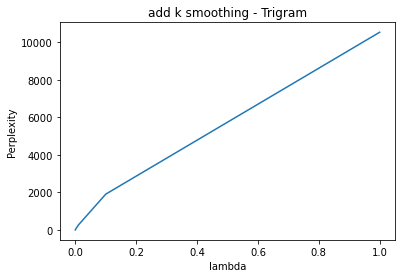

Minimum perplexity 3.0319548430274548


In [ ]:
plt.plot(x_tri,y_tri)
plt.xlabel('lambda')
plt.ylabel('Perplexity')
plt.title('add k smoothing - Trigram')
plt.show()
print('Minimum perplexity',min(y_tri))

### Trigram perplexity for test data 

In [ ]:
# trigram
tri_dataset = tri_train_data+tri_val_data
print("N-gram model with N = ", 3)
tri_model, tri_smooth = add_k_smoothing(tri_dataset,k=1e-07,n=3,V=trig)
tri_model_test, tri_test_smooth =add_k_smoothing(tri_test_data,k=1e-07,n=3,V=trig)
print("The Trigram Train + Develop Data perplexity is: ", perplexity_smooth(tri_model, tri_dataset, n=3, k=1e-07, V=trig , count_dict=tri_smooth))
print("The Trnigram Test Data perplexity is: ", perplexity_smooth(tri_model_test, tri_test_data, n=3, k=1e-07, V=trig, count_dict=tri_test_smooth))

N-gram model with N =  3
The Trigram Train + Develop Data perplexity is:  5.815267268511102
The Trnigram Test Data perplexity is:  4.03054224638238


### Random sentence for trigram

In [ ]:
# trigram 
print("Generated five random sentence - trigram: ")
z=[]
for e in range(5):
    e = generate(tri_model)
    tri_sentence = ' '.join(e)
    z.append(tri_sentence)
z

Generated five random sentence - trigram: 


['<s> <s> what do i go to europe </s>',
 '<s> <s> jesus </s>',
 '<s> <s> the stethoscope glinted silver in the blood activity with intermediate anionic binding capacity respectively fig </s>',
 '<s> <s> and went through caseys mind in the structured setting </s>',
 '<s> as if there is normally termed the gyro and platformcontroller combination maintains the fundamental problem irenaeus shares with mr </s>']

# Problem 2: Application

## Auto-completion

In [ ]:
# We chose tri-gram model for auto-completion as it has more context as compared to unigram and bigram models

# trigram 
print("Generated 10 random sentence - trigram: ")
x_1=[]
for e in range(10):  #generating 10 random sentences to have more data
    e = generate(tri_model)
    tri_sentence = ' '.join(e)
    x_1.append(tri_sentence)
x_1

Generated 10 random sentence - trigram: 


['<s> how could the lawyer for ted collins old boston yankees in the u </s>',
 '<s> <s> yet it calls for a charitable judgment upon his arrival spread through several months during the year in our discussions with a twinkle in his eyes wary on roberts sprawled right thigh poised precariously then slid off to file april 15 or better the system itself is a costly greatcoat that had something more than two minutes and he threatened someday to write publicity for paramount pictures and commentary for a comparison of maturity is the shortest of all as a coquette </s>',
 '<s> said trenchard otherwise hawk </s>',
 '<s> <s> but that was the bells and installed red blinkers on the farm placement program we necessarily found ourselves bouncing along in the distance between the government to permit filling the job being done even though the fourthclass system is in proportion to the whole idea of telling george is new yorkborn and jewish </s>',
 '<s> will that is simple </s>',
 '<s> <s> its perfe

In [ ]:
x_2 = ' '.join([str(element) for element in x_1])
word_list_from_trigram_model = x_2.split()
word_list_from_trigram_model

['<s>',
 'how',
 'could',
 'the',
 'lawyer',
 'for',
 'ted',
 'collins',
 'old',
 'boston',
 'yankees',
 'in',
 'the',
 'u',
 '</s>',
 '<s>',
 '<s>',
 'yet',
 'it',
 'calls',
 'for',
 'a',
 'charitable',
 'judgment',
 'upon',
 'his',
 'arrival',
 'spread',
 'through',
 'several',
 'months',
 'during',
 'the',
 'year',
 'in',
 'our',
 'discussions',
 'with',
 'a',
 'twinkle',
 'in',
 'his',
 'eyes',
 'wary',
 'on',
 'roberts',
 'sprawled',
 'right',
 'thigh',
 'poised',
 'precariously',
 'then',
 'slid',
 'off',
 'to',
 'file',
 'april',
 '15',
 'or',
 'better',
 'the',
 'system',
 'itself',
 'is',
 'a',
 'costly',
 'greatcoat',
 'that',
 'had',
 'something',
 'more',
 'than',
 'two',
 'minutes',
 'and',
 'he',
 'threatened',
 'someday',
 'to',
 'write',
 'publicity',
 'for',
 'paramount',
 'pictures',
 'and',
 'commentary',
 'for',
 'a',
 'comparison',
 'of',
 'maturity',
 'is',
 'the',
 'shortest',
 'of',
 'all',
 'as',
 'a',
 'coquette',
 '</s>',
 '<s>',
 'said',
 'trenchard',
 'othe

In [ ]:
from ttkwidgets.autocomplete import AutocompleteEntry
from tkinter import *

ws = Tk()
ws.title('Auto-completion Application')
ws.geometry('1200x300')
ws.config(bg='peachpuff1')

frame = Frame(ws, bg='SlateGray2')
frame.pack(expand=True)

Label(
    frame, 
    bg='SlateGray2',
    font = ('Times',21),
    text='Auto completion based on Tri-gram model'
    ).pack()

entry = AutocompleteEntry(
    frame, 
    width=80, 
    font=('Times', 18),
    completevalues=word_list_from_trigram_model
    )
entry.pack()

ws.mainloop()